In [1]:
import numpy as np
import pandas as pd
import os
import csv
from datetime import datetime
import json
import matplotlib.pyplot as plt

In [2]:
# Read in relevant data

quals = pd.read_csv('./kaggle_csvs/qualifying.csv')
drivers = pd.read_csv('./kaggle_csvs/drivers.csv')
races = pd.read_csv('./kaggle_csvs/races.csv')
lap_times = pd.read_csv('./kaggle_csvs/lap_times.csv')
lap_times = lap_times.sort_values(['raceId','driverId','lap'],ascending=[True,True,True])
lap_times = lap_times.reset_index(drop=True)
pits = pd.read_csv('./kaggle_csvs/pit_stops.csv')
results = pd.read_csv('./kaggle_csvs/results.csv')
status = pd.read_csv('./kaggle_csvs/status.csv')

In [3]:
# Create Directories for Race Files

dirs = [name for name in os.listdir('./races/') if os.path.isdir(os.path.join('./races/', name))]
for index, row in races.iterrows():
    name = str(row['year']) + ' ' + str(row['name'])
    d_n = './races/' + name
    if name not in dirs:
        os.mkdir(d_n)

In [4]:
# Parse files for timing, places, and intervals

# list all directories
dirs = [name for name in os.listdir('./races/') if os.path.isdir(os.path.join('./races/', name))]

# set blank for writing to CSVs
times = []
racer = []
places = []
first = lap_times.iloc[0]
race = lap_times.iloc[0]['raceId']
last = lap_times.iloc[-1]['raceId']
race_row = races.loc[races['raceId'] == last]

# if the file does not already exist
if not os.path.exists("./races/{} {}/total_times.csv".format(race_row['year'].item(),race_row['name'].item())):
    
    #for all laps
    for index, row in lap_times.iterrows():
        
        #if the first lap
        if row['lap'] == 1:

            if racer != []:
                times.append(racer)
                racer = []
                
            # add leading variables
            racer.append(row['raceId'])
            racer.append(row['driverId'])
            racer.append(drivers.loc[drivers['driverId'] == row['driverId']]['driverRef'].item())
            final_pos = results.loc[(results['raceId'] == race) & (results['driverId'] == row['driverId'])]
            racer.append(final_pos['constructorId'].item())
            racer.append(final_pos['positionOrder'].item())
            racer.append(final_pos['statusId'].item())
            st = status.loc[status['statusId'] == final_pos['statusId'].item()]
            racer.append(st['status'].item())
            racer.append(row['milliseconds'])
            header = ['raceId','driverId','driverRef','constructorId','positionOrder','statusId','status']
        
        # else, add the new lap
        else:
            racer.append(row['milliseconds']+racer[-1])
            
        # if the last lap has been completed, write to file
        if index == len(lap_times.index)-1 or lap_times.iloc[[index+1]]['raceId'].item() != race:
            
            # add relevant values to the total time lists
            race_row = races.loc[races['raceId'] == race]
            times.append(racer)
            total_times = pd.DataFrame(times)
            total_times = total_times.sort_values(7)
            total_times = total_times.drop(total_times.index[-1])
            
            # add headers for lap number and write
            for c in total_times.columns:
                if int(c) > 6:
                    header.append(int(c)-6)
            total_times.columns = header
            total_times.to_csv("./races/{} {}/total_times.csv".format(race_row['year'].item(),race_row['name'].item()))

            # for all times in total times, find the place of the driver and write
            for ind,r in total_times.iterrows():
                dr = [r['driverRef']]
                for c in total_times.columns:
                    if isinstance(c,int):
                        if r[c] != 0 and not pd.isna(r[c]):
                            dr.append(total_times[total_times[c]<r[c]].count()[c]+1)
                        else:
                            dr.append(0)
                places.append(dr)

            places = pd.DataFrame(places)
            places.to_csv("./races/{} {}/places.csv".format(race_row['year'].item(),race_row['name'].item()))

            #find the interval times and write
            intervals = np.array(total_times)
            for i in range(7,len(intervals[0])):
                intervals[:,i] -= np.nanmin(intervals[:,i])

            intervals = pd.DataFrame(intervals)
            intervals = intervals.drop(intervals.index[-1])
            intervals.to_csv("./races/{} {}/intervals.csv".format(race_row['year'].item(),race_row['name'].item()))

            if index != len(lap_times.index)-1:
                # reset variables
                race = lap_times.iloc[[index+1]]['raceId'].item()
                times = []
                racer = []
                places = []
            
print('done')

1
done


In [5]:
#function for comparing two lists with positions and copying the positions between the two for sorting
def complists(l1,l2):
    
    #sort lists based on position
    l1 = l1.sort_values(4,ignore_index=True)
    l2 = l2.sort_values(4,ignore_index=True)
    d1 = l1.iloc[:,3]
    d2 = l2.iloc[:,3]
    
    # corrolate lists
    order = []
    for i,d in l1.iterrows():
        if d[3] in list(d2):
            order.append([d[0],d[1],d[2],d[3],d2[d2==d[3]].index.values[0],l1.loc[l1[3] == d[3], 3].iloc[0]])
    
    #return previous lap ordering with current positions
    order = pd.DataFrame(order)
    order = np.array(order)
    return order

In [6]:
def swap(arr,j,orders,qt,n_pass,v_pass,pit=False):
    
    n_laps = orders[arr[j][1]][3]
    
    if j == 0:
        orders[arr[j+1][1]] = [None,0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,arr[2][3],0]
        behind = orders[arr[j+2][1]]
        orders[arr[j+2][1]] = [arr[j][3],0,behind[2],behind[3]]
    elif j == len(arr)-2:
        orders[arr[j+1][1]] = [arr[j-1][3],0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,None,0]
        ahead = orders[arr[j-1][1]]
        orders[arr[j-1][1]] = [ahead[0],ahead[1],arr[j+1][3],0]
    else:
        orders[arr[j+1][1]] = [arr[j-1][3],0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,arr[j+2][3],0]
        behind = orders[arr[j+2][1]]
        orders[arr[j+2][1]] = [arr[j][3],0,behind[2],behind[3]]
        ahead = orders[arr[j-1][1]]
        orders[arr[j-1][1]] = [ahead[0],ahead[1],arr[j+1][3],0]
        
    if pit:
        arr[j], arr[j+1] = arr[j+1], arr[j]
        return
    
    #Qualis do not account for rain days which cause extreme qualifying differences
    
    tf = qt[qt[0] == int(arr[j+1][1])]
    
    if len(tf.index) == 0 or tf[2].item() == '3:00.00':
        d = [arr[j+1][1],arr[j+1][2]]
        temp = qt[qt[1] == int(arr[j+1][2])]
        d.append(temp[2].min())
        tf = pd.DataFrame([d])
        
        #missing qualifying entirely
        if pd.isna(tf[2].item()):
            arr[j], arr[j+1] = arr[j+1], arr[j]
            return 0,0
    
    ts = qt[qt[0] == int(arr[j][1])]
    
    if len(ts.index) == 0 or ts[2].item() == '3:00.00':
        d = [arr[j][1],arr[j][2]]
        temp = qt[qt[1] == int(arr[j][2])]
        d.append(temp[2].min())
        ts = pd.DataFrame([d])
        
        #missing qualifying entirely
        if pd.isna(ts[2].item()):
            arr[j], arr[j+1] = arr[j+1], arr[j]
            return 0,0

    #convert to datetime
    qf = datetime.strptime(tf[2].item(), '%M:%S.%f')
    qs = datetime.strptime(ts[2].item(), '%M:%S.%f')
        
    f_laps = list(orders[arr[j+1][1]])
    s_laps = list(orders[arr[j][1]])

    v_f = v_pass[arr[j+1][3]]
    v_s = v_pass[arr[j][3]]
    t = datetime(1900,1,1,0,0)
    #single lap expected overtake probability
    ot_prob = 1/(1+10**((v_f[0]-v_s[1]+600*(qf-qs).total_seconds())/400))
    #ot_probf = 1/(1+10**((v_s[1]-v_f[0])/400))
    #ot_probs = 1/(1+10**((v_f[0]-v_s[1])/400))
    p_no_ot = (1-ot_prob)**n_laps
    if p_no_ot < .5:
        print(p_no_ot)
    off_val = min(16*(-.5+p_no_ot),8)
    d_val = max(16*(.5-p_no_ot),-8)
    v_pass[arr[j+1][3]] = [v_f[0]+off_val,v_f[1]]
    v_pass[arr[j][3]] = [v_s[0],v_s[1]+d_val]

    n_f = n_pass[arr[j+1][3]]
    n_pass[arr[j+1][3]] = [n_f[0]+1,n_f[1]]
    n_s = n_pass[arr[j][3]]
    n_pass[arr[j][3]] = [n_s[0],n_s[1]+1]
    arr[j], arr[j+1] = arr[j+1], arr[j]
    
    #return (qs-qf).total_seconds(),n_laps
    return p_no_ot,n_laps

In [7]:
#bubble sort lists. Fast because mosly ordered. Makes tracking overtaking easy because of the bubble method
def bubbleSort(arr,n_pass,v_pass,qt,orders,pits):
    #set number of laps and set total overtakes to 0
    n = len(arr)
    ot = 0
    times = []
    
    #for each row, bubble sort
    for i in range(n):
        for j in range(0,n-1-i):
            #if the position is higher than the one below
            if arr[j][4] > arr[j+1][4]:
                if int(arr[j+1][1]) in pits or int(arr[j][1]) in pits:
                    diff = swap(arr,j,orders,qt,n_pass,v_pass,pit=True)
                else:
                    diff,laps = swap(arr,j,orders,qt,n_pass,v_pass)
                    ot += 1
                    times.append([diff,laps])
                
    return ot, times

In [8]:
def overtakes(filename,n_pass,v_pass,pits,quals,dr_o,dr_p,rm=True):
    if os.path.exists(filename):
        diffs = []
        print(filename)
        laptimes = pd.read_csv(filename)
        raceId = laptimes['raceId']
        if int(raceId[0]) > 840:
            driverId = laptimes['driverId']
            constructorId = laptimes['constructorId']
            racers = laptimes.iloc[:,3]
            prev = laptimes.iloc[:,8]
            prev = pd.concat([raceId,driverId,constructorId,racers,prev],keys=[0,1,2,3,4],axis=1)
            orders = {}
            for p in range(len(prev)):
                if p == 0:
                    orders[prev[1][p]] = [None,0,prev[1][p+1],0]
                elif p == len(prev)-1:
                    orders[prev[1][p]] = [prev[1][p-1],0,None,0]
                else:
                    orders[prev[1][p]] = [prev[1][p-1],0,prev[1][p+1],0]
            stops = pits.loc[pits['raceId'] == raceId[0]]
            qt = quals.loc[quals['raceId'] == raceId[0]]
            if qt.empty:
                return
            did = [list(qt['driverId']),list(qt['constructorId'])]
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].fillna('3:00.00')
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].replace(r"\N",'3:00.00')
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].replace(r"\\N",'3:00.00')
            did.append(list(qt[['q1','q2','q3']].dropna().min(axis=1)))
            did = list(map(list, zip(*did)))
            qt = pd.DataFrame(did)
            tot_ots = 0
            l_b = {}
            for r in laptimes['driverRef']:
                l_b[r] = []
            for c in laptimes.columns[8:]:
                times = laptimes[c]
                times = pd.concat([raceId,driverId,constructorId,racers,times],keys=[0,1,2,3,4],axis=1)
                times.dropna(subset = [4], inplace=True)
                pitted = []
                if rm:
                    if int(c)-1 in list(stops['lap']):
                        rows = stops[stops['lap'] == int(c)-1]
                        for i,r in rows.iterrows():
                            times = times[times[1] != r[1]]
                            prev = prev[prev[1] != r[1]]
                            pitted.append(r[1])
                changes = complists(prev,times)
                ots, diff = bubbleSort(changes,n_pass,v_pass,qt,orders,pitted)
                tot_ots += ots
                diffs = diffs + diff
                for i in range(len(times.index)):
                    if i == len(times.index)-1:
                        t = times.iloc[i]
                        l = l_b[t[3]]
                        ods = orders[t[1]]
                        l.append([ods[1],ods[3]])
                        l_b[t[3]] = l
                        continue
                    f = times.iloc[i]
                    s = times.iloc[i+1]
                    if abs(f[4]-s[4])/1000 < 1.2:
                        odf = orders[f[1]]
                        ods = orders[s[1]]
                        orders[f[1]] = [odf[0],odf[1],odf[2],odf[3]+1]
                        orders[s[1]] = [ods[0],ods[1]+1,ods[2],ods[3]]
                    odf = orders[f[1]]
                    l = l_b[f[3]]
                    l.append([odf[1],odf[3]])
                    l_b[f[3]] = l
                prev = laptimes[c]
                prev = pd.concat([raceId,driverId,constructorId,racers,prev],keys=[0,1,2,3,4],axis=1)
            with open('{}total_overtakes.txt'.format(filename[:-15]), 'w') as f:
                f.write('%d' % tot_ots)
            with open('{}laps.txt'.format(filename[:-15]), 'w') as convert_file:
                convert_file.write(json.dumps(l_b))
                
        return diffs

In [9]:
n_pass = {}
v_pass ={}
dr_o = {}
dr_p = {}
diffs = []
for r in drivers['driverRef']:
    n_pass[r] = [0,0]
    v_pass[r] = [1500,1500]
    dr_o[r] = []
    dr_p[r] = []

races = races.sort_values(by=['date'])
for r in races.iterrows():
    d = str(r[1]['year']) + ' ' + r[1]['name']
    diff = overtakes('./races/{}/total_times.csv'.format(d),n_pass,v_pass,pits,quals,dr_o,dr_p)
    if diff != None:
        diffs = diffs + diff

for k in list(n_pass.keys()):
    if n_pass[k] == [0,0]:
        n_pass.pop(k)
        v_pass.pop(k)
    if dr_o[k] == []:
        dr_o.pop(k)
    if dr_p[k] == []:
        dr_p.pop(k)

./races/1996 Australian Grand Prix/total_times.csv
./races/1996 Brazilian Grand Prix/total_times.csv
./races/1996 Argentine Grand Prix/total_times.csv
./races/1996 European Grand Prix/total_times.csv
./races/1996 San Marino Grand Prix/total_times.csv
./races/1996 Monaco Grand Prix/total_times.csv
./races/1996 Spanish Grand Prix/total_times.csv
./races/1996 Canadian Grand Prix/total_times.csv
./races/1996 French Grand Prix/total_times.csv
./races/1996 British Grand Prix/total_times.csv
./races/1996 German Grand Prix/total_times.csv
./races/1996 Hungarian Grand Prix/total_times.csv
./races/1996 Belgian Grand Prix/total_times.csv
./races/1996 Italian Grand Prix/total_times.csv
./races/1996 Portuguese Grand Prix/total_times.csv
./races/1996 Japanese Grand Prix/total_times.csv
./races/1997 Australian Grand Prix/total_times.csv
./races/1997 Brazilian Grand Prix/total_times.csv
./races/1997 Argentine Grand Prix/total_times.csv
./races/1997 San Marino Grand Prix/total_times.csv
./races/1997 Mo

./races/2006 Spanish Grand Prix/total_times.csv
./races/2006 Monaco Grand Prix/total_times.csv
./races/2006 British Grand Prix/total_times.csv
./races/2006 Canadian Grand Prix/total_times.csv
./races/2006 United States Grand Prix/total_times.csv
./races/2006 French Grand Prix/total_times.csv
./races/2006 German Grand Prix/total_times.csv
./races/2006 Hungarian Grand Prix/total_times.csv
./races/2006 Turkish Grand Prix/total_times.csv
./races/2006 Italian Grand Prix/total_times.csv
./races/2006 Chinese Grand Prix/total_times.csv
./races/2006 Japanese Grand Prix/total_times.csv
./races/2006 Brazilian Grand Prix/total_times.csv
./races/2007 Australian Grand Prix/total_times.csv
./races/2007 Malaysian Grand Prix/total_times.csv
./races/2007 Bahrain Grand Prix/total_times.csv
./races/2007 Spanish Grand Prix/total_times.csv
./races/2007 Monaco Grand Prix/total_times.csv
./races/2007 Canadian Grand Prix/total_times.csv
./races/2007 United States Grand Prix/total_times.csv
./races/2007 French 

/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.4606279681227253
0.1449838694698884
0.00025395933342491897
./races/2011 Malaysian Grand Prix/total_times.csv
0.0016360217343593941
0.0783331491084983
0.0007026811677541715
0.49167403574762747


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


3.2580104991836175e-11
0.2135681178564891
0.3652584700043624
2.678178214741558e-06
0.0042196254349121665
./races/2011 Chinese Grand Prix/total_times.csv
0.0005707289040081109
0.1600461976483073
0.023792709102823606
0.3008109395881291
0.2753271172056159
0.040984368736595826
0.3649522866806323
0.15390940583428092


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.2769050687517366
4.542402920471034e-06
0.10677695314438862
0.0004664962866457456
0.0050228070145263305
0.12175485116566209
0.12125930916882321
0.4736798184922356
0.1511961375983888
0.24797194644728981
0.14624430937125754
0.4650494295462584
./races/2011 Turkish Grand Prix/total_times.csv
0.00973508054457728
2.711387272358312e-05
1.990776225202026e-07
0.0003604104135317849
0.011486175110761443
0.0010291397154865711
0.3202593851743276
1.0631403868366363e-08
0.002384202151576552
0.010788234550086373


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.3693582143123767
0.39820129880361765
0.26955097766450353
0.39510369998622563
./races/2011 Spanish Grand Prix/total_times.csv
0.07432946693463849
0.00011950230756023604
0.05328246086932993


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.037808031849724394
0.09855070988181391
0.00028461095996257235
4.670667790182426e-06
0.00011217628827753234
0.00011217860601153706
0.1875697333357602
./races/2011 Monaco Grand Prix/total_times.csv
0.0012453480208396012
0.03761263444881169


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


3.1016835174701995e-06
1.7242062250224583e-66
9.84984984971371e-06
1.5073858006713514e-07
./races/2011 Canadian Grand Prix/total_times.csv
0.471808123420397
0.24224391234073792
0.002638555751373215
0.02980709818552507
0.2573514890532827


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0829525959200637
5.5018071455137374e-05
./races/2011 European Grand Prix/total_times.csv
5.504375482856538e-06
0.007920890820774502
0.40580550562387974
0.11465856809482168
0.42093942051212174


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 British Grand Prix/total_times.csv
0.4653873843883537
0.02459280335403269
0.004373312348471939


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.04502199542880466
./races/2011 German Grand Prix/total_times.csv
1.4326304847989135e-06
8.382194666116506e-08
0.09033674944282824
0.4825498278464555


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.37937646574317774
0.000364457022412501
./races/2011 Hungarian Grand Prix/total_times.csv
0.1326153908374029
0.006976696367005106
0.32910992009218054
0.12698410870037496
0.41932078721380156
6.693576554818956e-06


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.2663072391986232
0.006245007184400575
0.004686034121606423
./races/2011 Belgian Grand Prix/total_times.csv
0.0
3.578226603906387e-11
6.788548101900109e-06
0.0
9.686938963082703e-06
0.0
0.4561477943934465
0.002486703995939754
0.0


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0941783529467769
2.2409797698876245e-09
3.084125650688873e-10
5.728826403091539e-05
9.224017250230822e-08
./races/2011 Italian Grand Prix/total_times.csv
0.0014161806054932002
0.035290961343305574
1.555415922926963e-05


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.3533615322076843
0.0033520425458219167
0.00010964997852302982
0.29988133199236733
./races/2011 Singapore Grand Prix/total_times.csv
0.006254093150781093
0.36141608023862365
6.599436710145847e-60
5.982844637832971e-09


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0029372628164268375
1.5834178995809035e-08
0.12464041705831086
0.01367996335758781
0.29387922611664297
0.3150895647305777
./races/2011 Japanese Grand Prix/total_times.csv
0.010535146473765633
9.951788397022376e-06
2.469733207689402e-08
0.0002643230890029269
9.588266098238859e-06
9.206605280419077e-09


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.010085358447022519
8.506533067283789e-05
./races/2011 Korean Grand Prix/total_times.csv
0.026107186090848278
0.0002545327213441251
0.0018944779369161058
0.005780269954888526
0.00024309104115904923


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Indian Grand Prix/total_times.csv
0.36830643060945395


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.00045878959165635
./races/2011 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.00012654143165824472
0.01991648094501619
2.0133529899953444e-09
3.835433608379013e-06
2.4949041964809404e-24
./races/2011 Brazilian Grand Prix/total_times.csv
0.13439709809192402


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.2734533763097319
0.12675346153838984
./races/2012 Australian Grand Prix/total_times.csv
0.0001451342052978255
0.0010919729473426454
0.14004252547572196


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.012305541173731048
./races/2012 Malaysian Grand Prix/total_times.csv
0.0628397699877562
0.03591860984297979


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.4052060849160012
./races/2012 Chinese Grand Prix/total_times.csv
0.0027983349097228105


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0008721066898789522
./races/2012 Bahrain Grand Prix/total_times.csv
0.40175377425054026


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Spanish Grand Prix/total_times.csv
1.2580074687518206e-06
0.0013833293288835202
0.0002945144661488097


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Monaco Grand Prix/total_times.csv
2.2988707412326495e-31


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.00015283693254708778
0.4341930586380484
./races/2012 Canadian Grand Prix/total_times.csv
0.03387499131768834
0.31162778678616676


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.02734265177353472
./races/2012 European Grand Prix/total_times.csv
3.3389640869630484e-05


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 British Grand Prix/total_times.csv
5.938375739011903e-05
0.12637265754451749
0.1125808557682246


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.40489147891144217
./races/2012 German Grand Prix/total_times.csv
0.12630297243909805
0.00022798992571648746


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Belgian Grand Prix/total_times.csv
0.0005636773818620064
0.0038693203235753426


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Italian Grand Prix/total_times.csv
0.07713328663544228
0.38262751053999344


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Singapore Grand Prix/total_times.csv
0.02848033274639745
0.0018815964584680408
2.349663900338578e-08


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.03886077783663244
0.0005027255007664356
./races/2012 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.13133858291990808
0.0013534834768954562
./races/2012 Korean Grand Prix/total_times.csv
0.07177790330068934
0.0027623719781744677


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Indian Grand Prix/total_times.csv
0.06711755970050338
0.0019132577520092342


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Abu Dhabi Grand Prix/total_times.csv
5.998511706872822e-05
1.3890724602854921e-18


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.006644319015364991
./races/2012 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Brazilian Grand Prix/total_times.csv
9.253324128722857e-06
8.402763048887202e-14


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.004686760091876185
4.51357813013864e-07
./races/2013 Australian Grand Prix/total_times.csv
0.000901698224119843
1.5446389562293174e-27
0.0


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


8.341121127131146e-10
./races/2013 Malaysian Grand Prix/total_times.csv
2.2092738874435144e-07


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Chinese Grand Prix/total_times.csv
0.011912814658439186
0.008664698680356464
0.48032378585543967
0.47941913144952775


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Bahrain Grand Prix/total_times.csv
0.11419259570147355
0.18361043209683114


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.005076474827735877
./races/2013 Spanish Grand Prix/total_times.csv
0.004662966957696635


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


8.947522604021534e-19
6.9127229045014615e-18
0.0077444208677917015
./races/2013 Canadian Grand Prix/total_times.csv
3.541130144060338e-11


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 British Grand Prix/total_times.csv
0.2998546132472778
0.006034160549917789
0.45662236634423836
8.801268325486526e-14


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


1.3575256539522966e-06
./races/2013 German Grand Prix/total_times.csv
0.012475924102681946


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.4943968065275572
0.08742707196751558
./races/2013 Hungarian Grand Prix/total_times.csv
0.002504592956541818


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.4203879847420603
0.004611472440638531
./races/2013 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.004861151827011406
0.00031992685534398824
6.173494378656384e-22
./races/2013 Korean Grand Prix/total_times.csv
0.15464119355609585
0.24665581593838526


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.18942612610953324
./races/2013 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Indian Grand Prix/total_times.csv
0.0002428045600488815
0.0868234370865757


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Abu Dhabi Grand Prix/total_times.csv
0.01998098190077846


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Australian Grand Prix/total_times.csv
6.174661076693e-06
0.3249212814260778
0.44848175709920757


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


9.46438892469583e-06
0.37768615571270403
./races/2014 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


2.0285146448140168e-05
0.26924480971153575
./races/2014 Bahrain Grand Prix/total_times.csv
0.2888244869576806


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Chinese Grand Prix/total_times.csv
0.035073996241219325


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.05522998746420978
./races/2014 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Canadian Grand Prix/total_times.csv
0.07344504862730461


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 British Grand Prix/total_times.csv
4.4853010194856324e-14
3.3306690738754696e-15


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 German Grand Prix/total_times.csv
0.40253313082072373
0.02759685679813586


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Hungarian Grand Prix/total_times.csv
3.909795331380472e-06
1.784154707262786e-05
0.00019778411352577852


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.045610923582513084
0.21283497164981102
./races/2014 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


1.0663313934048058e-17
0.3598009054128932
0.005868440566771604
2.8736108893009302e-05
./races/2014 Italian Grand Prix/total_times.csv
0.010617134721358945


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Singapore Grand Prix/total_times.csv
2.2404549375520943e-05


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Japanese Grand Prix/total_times.csv
0.09252818497970233


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.13724075701974814
./races/2014 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Malaysian Grand Prix/total_times.csv
0.001683914729326019


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Chinese Grand Prix/total_times.csv
0.38950677539306866


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.43725504520984554
0.44747488063900415
./races/2015 Monaco Grand Prix/total_times.csv
2.269632637164065e-06
0.004708085787689109


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Canadian Grand Prix/total_times.csv
0.046681031199043


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Austrian Grand Prix/total_times.csv
0.004147468988568973
9.504354633427248e-06


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Hungarian Grand Prix/total_times.csv
0.00048808230450436696


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Italian Grand Prix/total_times.csv
0.07729490254419069
0.0001305765987171803


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Singapore Grand Prix/total_times.csv
0.1566331760323293


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Japanese Grand Prix/total_times.csv
1.3796392284826098e-05
0.0


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Russian Grand Prix/total_times.csv
5.997299714034761e-13
0.07402105585661577


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 United States Grand Prix/total_times.csv
0.17091766417046783


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Mexican Grand Prix/total_times.csv
0.0017349082775121039


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Brazilian Grand Prix/total_times.csv
0.00034870697701649966


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Australian Grand Prix/total_times.csv
0.39006837602826805
0.03218839538073348


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Chinese Grand Prix/total_times.csv
0.4550735595697924
0.01688859541649823


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.058401867852633016
./races/2016 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.053839320365870184
./races/2016 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 European Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0344106712998445
./races/2016 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Hungarian Grand Prix/total_times.csv
1.8380788484096736e-13


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0
0.0
./races/2016 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Mexican Grand Prix/total_times.csv
0.49167124327381073


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Australian Grand Prix/total_times.csv
0.04052763869278949


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Chinese Grand Prix/total_times.csv
0.4731100226330235


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Russian Grand Prix/total_times.csv
0.2844121553279694


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.022497285627369423
./races/2017 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 British Grand Prix/total_times.csv
1.0241256176435343e-08


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Belgian Grand Prix/total_times.csv
0.1777426439957537


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Italian Grand Prix/total_times.csv
0.15396117408602994


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 United States Grand Prix/total_times.csv
0.00012691505445289238


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.09771527234884392
./races/2017 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0013048923172376003
./races/2018 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Bahrain Grand Prix/total_times.csv
0.09268281974314685
0.07289487464910682


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.09082739632553294
./races/2018 Chinese Grand Prix/total_times.csv
0.01704103750514294
0.006611726784129865


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.22335253626672236
./races/2018 Azerbaijan Grand Prix/total_times.csv
8.215650382226158e-15
0.17309827304388437


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0
./races/2018 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Monaco Grand Prix/total_times.csv
0.2583994851158621


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.003138696097443206
./races/2018 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.15739486211288464
./races/2018 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Abu Dhabi Grand Prix/total_times.csv
0.00011571417154718607


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Bahrain Grand Prix/total_times.csv
0.2063581744566213
0.10087974879845257
0.017901382152415636


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.1864067293347057
0.2392172146519257
0.002671798506540737
./races/2019 Chinese Grand Prix/total_times.csv
0.00101163608228938


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Azerbaijan Grand Prix/total_times.csv
3.361193044881338e-10
0.41479093567732006


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Spanish Grand Prix/total_times.csv
1.5227876814193502e-07


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


1.581596387953813e-12
./races/2019 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 German Grand Prix/total_times.csv
0.06260537984188286


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Italian Grand Prix/total_times.csv
0.1681351627916874
0.01913421947360161


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Russian Grand Prix/total_times.csv
0.0044540762258855615


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.007584034552008301
3.3055576639943362e-06
./races/2019 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Abu Dhabi Grand Prix/total_times.csv
1.5817724518485996e-16


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.3864320536387587
./races/2020 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Styrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


1.4651481805987735e-06
./races/2020 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 70th Anniversary Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.08042407756680861
./races/2020 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Tuscan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Eifel Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Portuguese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Emilia Romagna Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Turkish Grand Prix/total_times.csv
0.0
1.0006266256595985e-23
0.0


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Bahrain Grand Prix/total_times.csv
0.060281485681719156


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Sakhir Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.305723981407406
0.0038960461965537236
./races/2020 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


2.7791215130841683e-09
./races/2021 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Emilia Romagna Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Portuguese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.03437398010363531
0.06235994555253284
./races/2021 Spanish Grand Prix/total_times.csv
0.25564340203096025
0.11459158430995438
0.21903261995254386


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.12543650894348132
./races/2021 Azerbaijan Grand Prix/total_times.csv
0.27884832466263143


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 French Grand Prix/total_times.csv
0.004355804641156813


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Styrian Grand Prix/total_times.csv
0.4341493589666371


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.014547251401409445
0.44988025964799927
0.16592892589477332
./races/2021 Austrian Grand Prix/total_times.csv
0.2582879776018182


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 British Grand Prix/total_times.csv
0.21612860487743235


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Belgian Grand Prix/total_times.csv
./races/2021 Dutch Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Russian Grand Prix/total_times.csv
4.56328260229376e-14
1.687241488745883e-07


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Turkish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 United States Grand Prix/total_times.csv
3.922571090053633e-06


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Mexico City Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 São Paulo Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Qatar Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Saudi Arabian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


10695


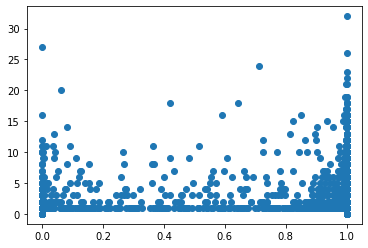

In [10]:
x = []
y = []

print(len(diffs))

for i in diffs:
    x.append(i[0])
    y.append(i[1])

plt.scatter(x,y)

(array([  261.,    39.,    22.,    19.,    27.,    28.,    26.,    31.,
           40.,    70., 10132.]),
 array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
        0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
        0.90909091, 1.        ]),
 <BarContainer object of 11 artists>)

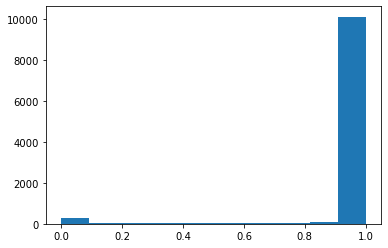

In [11]:
plt.hist(x,bins=11)

In [12]:
for k in list(n_pass.keys()):
    print(k)
    print(n_pass[k])

hamilton
[532, 227]
heidfeld
[35, 40]
rosberg
[285, 231]
alonso
[461, 395]
kovalainen
[80, 166]
raikkonen
[526, 397]
kubica
[4, 73]
glock
[32, 133]
massa
[403, 315]
trulli
[28, 61]
sutil
[144, 162]
webber
[223, 111]
button
[320, 332]
vettel
[541, 288]
barrichello
[64, 63]
liuzzi
[13, 45]
michael_schumacher
[140, 104]
rosa
[24, 68]
karthikeyan
[21, 74]
buemi
[78, 66]
alguersuari
[79, 58]
grosjean
[412, 416]
kobayashi
[154, 160]
gasly
[222, 184]
hulkenberg
[367, 380]
petrov
[114, 137]
bruno_senna
[69, 83]
chandhok
[0, 2]
maldonado
[253, 290]
resta
[207, 199]
perez
[656, 482]
ambrosio
[17, 63]
ricciardo
[606, 427]
vergne
[199, 188]
pic
[52, 107]
chilton
[24, 73]
gutierrez
[141, 230]
bottas
[374, 300]
garde
[18, 55]
jules_bianchi
[23, 95]
kevin_magnussen
[193, 376]
kvyat
[290, 271]
ericsson
[136, 272]
stevens
[6, 30]
max_verstappen
[322, 160]
nasr
[89, 131]
sainz
[376, 300]
merhi
[4, 25]
rossi
[4, 17]
jolyon_palmer
[57, 114]
wehrlein
[59, 111]
haryanto
[5, 40]
vandoorne
[59, 80]
ocon
[163,

In [13]:
for k in list(v_pass.keys()):
    print(k)
    print(v_pass[k])

hamilton
[5454.055234137789, -291.62112122297]
heidfeld
[1726.6539470933415, 1219.7964914780075]
rosberg
[3644.8090019015176, -135.95633770238547]
alonso
[5048.996245198974, -1574.2066575535746]
kovalainen
[2031.7490446918102, 552.7336281777327]
raikkonen
[5618.802365554224, -1642.499911187644]
kubica
[1531.9999750985426, 1117.1702656616674]
glock
[1693.0505969017734, 785.0735760582972]
massa
[4509.670677400576, -901.96251746859]
trulli
[1632.5496327909718, 1245.1949615501348]
sutil
[2521.6269179767573, 265.7449724472776]
webber
[3048.76274512033, 640.0290710710627]
button
[3826.042207011488, -1060.7423722450517]
vettel
[5668.398524258636, -777.5695923547989]
barrichello
[1848.1802545739445, 1081.7702740786374]
liuzzi
[1592.3752540209557, 1323.6826535776784]
michael_schumacher
[2444.636131648094, 790.2838203457076]
rosa
[1656.963590487337, 1099.4258256625455]
karthikeyan
[1658.025219107681, 1080.9535686205559]
buemi
[1933.4522890435965, 1069.1416222230625]
alguersuari
[2018.38847829120

In [14]:
races = races.sort_values(by=['date'])
for r in races.iterrows():
    d = str(r[1]['year']) + ' ' + r[1]['name']
    print(d)

1950 British Grand Prix
1950 Monaco Grand Prix
1950 Indianapolis 500
1950 Swiss Grand Prix
1950 Belgian Grand Prix
1950 French Grand Prix
1950 Italian Grand Prix
1951 Swiss Grand Prix
1951 Indianapolis 500
1951 Belgian Grand Prix
1951 French Grand Prix
1951 British Grand Prix
1951 German Grand Prix
1951 Italian Grand Prix
1951 Spanish Grand Prix
1952 Swiss Grand Prix
1952 Indianapolis 500
1952 Belgian Grand Prix
1952 French Grand Prix
1952 British Grand Prix
1952 German Grand Prix
1952 Dutch Grand Prix
1952 Italian Grand Prix
1953 Argentine Grand Prix
1953 Indianapolis 500
1953 Dutch Grand Prix
1953 Belgian Grand Prix
1953 French Grand Prix
1953 British Grand Prix
1953 German Grand Prix
1953 Swiss Grand Prix
1953 Italian Grand Prix
1954 Argentine Grand Prix
1954 Indianapolis 500
1954 Belgian Grand Prix
1954 French Grand Prix
1954 British Grand Prix
1954 German Grand Prix
1954 Swiss Grand Prix
1954 Italian Grand Prix
1954 Spanish Grand Prix
1955 Argentine Grand Prix
1955 Monaco Grand Pr